In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import * 
from functions.pipeline_helpers import *

In [2]:
data=pl.read_csv("../data/W1_carPrices/CarPrice_Assignment.csv")
data.head()

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
1,3,"""alfa-romero giulia""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,"""alfa-romero stelvio""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,"""alfa-romero Quadrifoglio""","""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,"""audi 100 ls""","""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
5,2,"""audi 100ls""","""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0


In [3]:
cat_cols=[col for col in data.columns if data[col].dtype == pl.String]
num_cols=[col for col in data.drop("car_ID","price").columns if data[col].dtype!= pl.String]

### Splitting data to avoiding data leakages [Learn more](https://en.wikipedia.org/wiki/Leakage_(machine_learning))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data[["car_ID","price"]],test_size=0.3,random_state=42,shuffle=True,stratify=data[['symboling']])
train_data=X_train.join(y_train,on="car_ID")
test_data=X_test.join(y_test,on="car_ID")
train_data.shape,test_data.shape

((143, 26), (62, 26))

random state 42 for every process for consistency

## Data Preprocessing

### Target Mean Encoding ##

extracting brand names

In [5]:
l=data["CarName"].str.split(" ")
brands=[]
for i in l:
    brands.append(i[0])
data=data.with_columns(pl.Series(brands).alias("CarName"))
data=data.with_columns(data["CarName"].str.replace("porsche","porcshce"))

In [6]:
train_data=train_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")
test_data=test_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")

In [7]:
encoder_list=train_data[['CarName','price']].group_by(["CarName"]).agg(pl.median("price")).sort(by="price")
encoder_list

CarName,price
str,f64
"""Nissan""",5499.0
"""maxda""",5645.0
"""chevrolet""",6435.0
"""plymouth""",6919.0
"""honda""",7295.0
…,…
"""volvo""",18420.0
"""bmw""",27662.5
"""porcshce""",31964.25


In [8]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='quantile') # from power bi report 4 bins looks good

discretizer.fit(encoder_list[['price']])
bins = discretizer.transform(encoder_list[['price']])

# Print bin labels (array format)
encoder_list=encoder_list.hstack(pl.DataFrame(bins,schema=["carclass"]))
encoder_list

CarName,price,carclass
str,f64,f64
"""Nissan""",5499.0,0.0
"""maxda""",5645.0,0.0
"""chevrolet""",6435.0,0.0
"""plymouth""",6919.0,0.0
"""honda""",7295.0,0.0
…,…,…
"""volvo""",18420.0,3.0
"""bmw""",27662.5,3.0
"""porcshce""",31964.25,3.0


Checking for new brands in test

In [9]:
for i in set(test_data["CarName"]):
    if i not in set(train_data["CarName"]):
        print(i)

No new brands in test set,otherwise some replacing techniques should be adadpted like knnclassifer to guess closer brand

In [10]:
def mean_encoder(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty(): # For new brands imputing with mean prices
        return encoder_list['price'].median()
    return encoder_list.filter(encoder_list['CarName']==x)['price'][0]
def car_class(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty(): # For new brands imputing with mean prices
        return encoder_list['carclass'].median()                     
    return encoder_list.filter(encoder_list['CarName']==x)["carclass"][0]
    
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")

In [11]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

### Categorical EDA

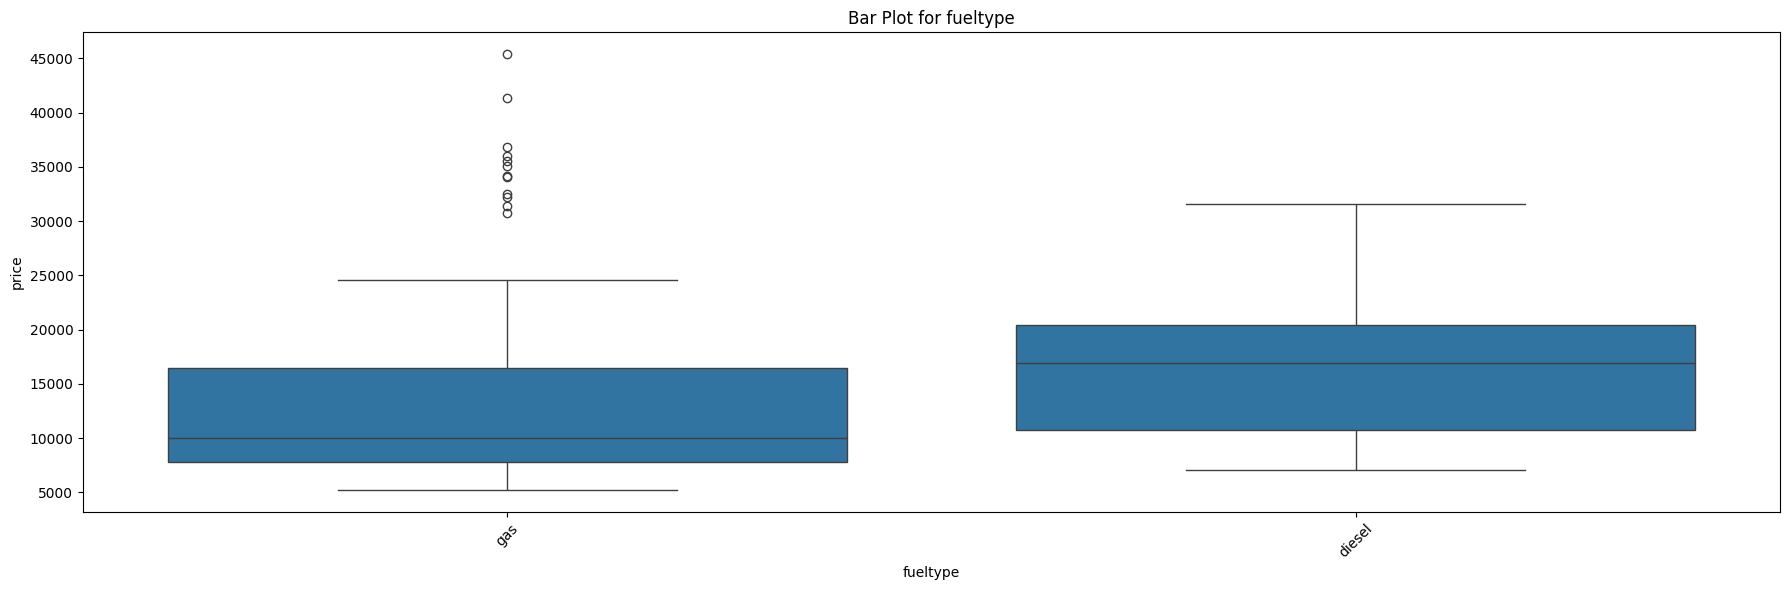

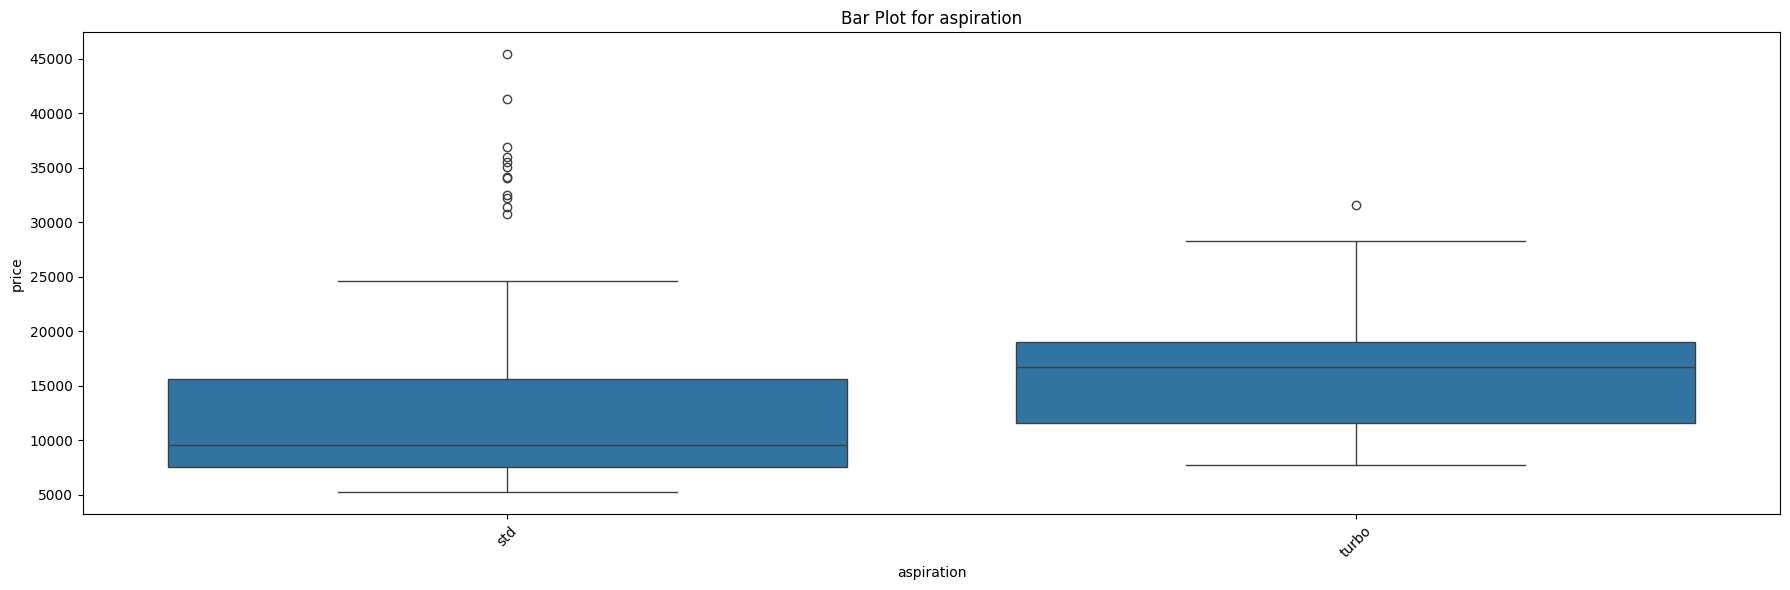

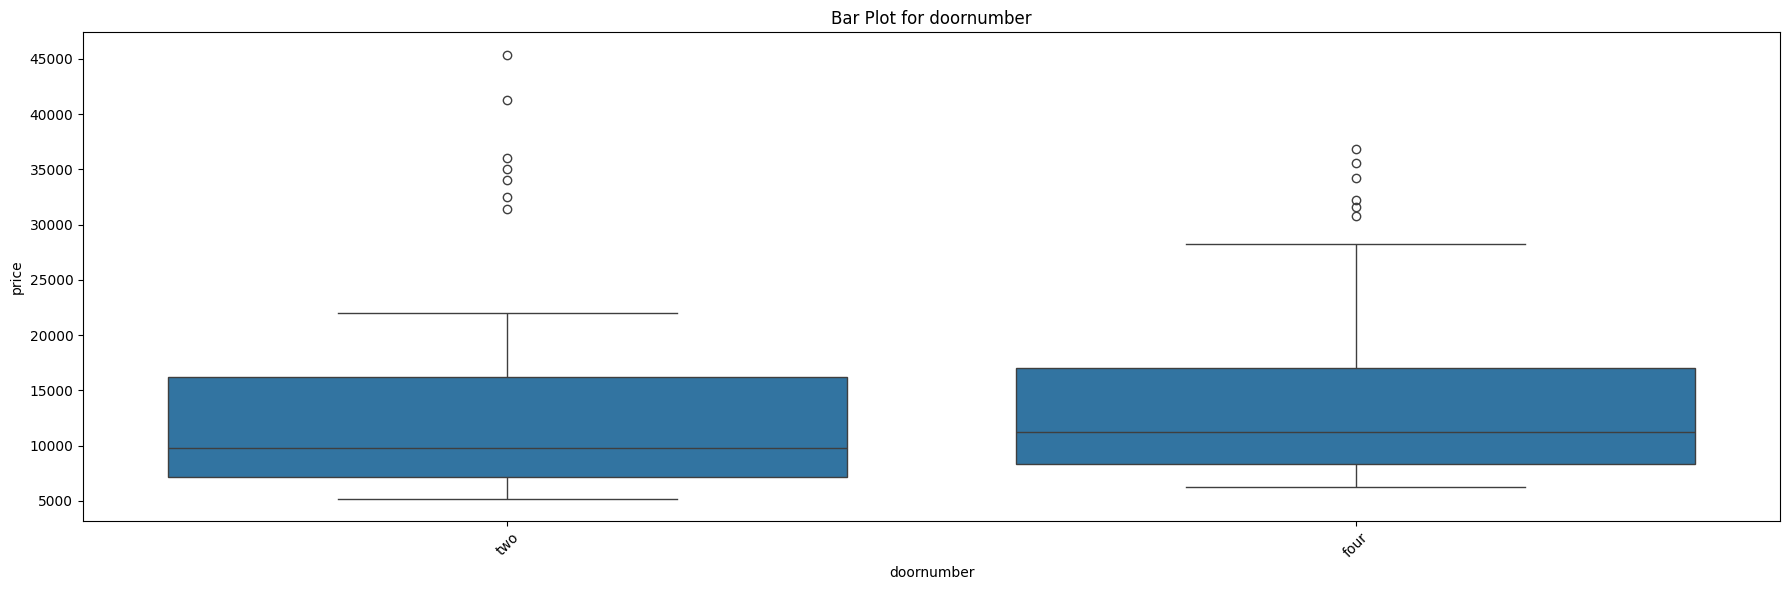

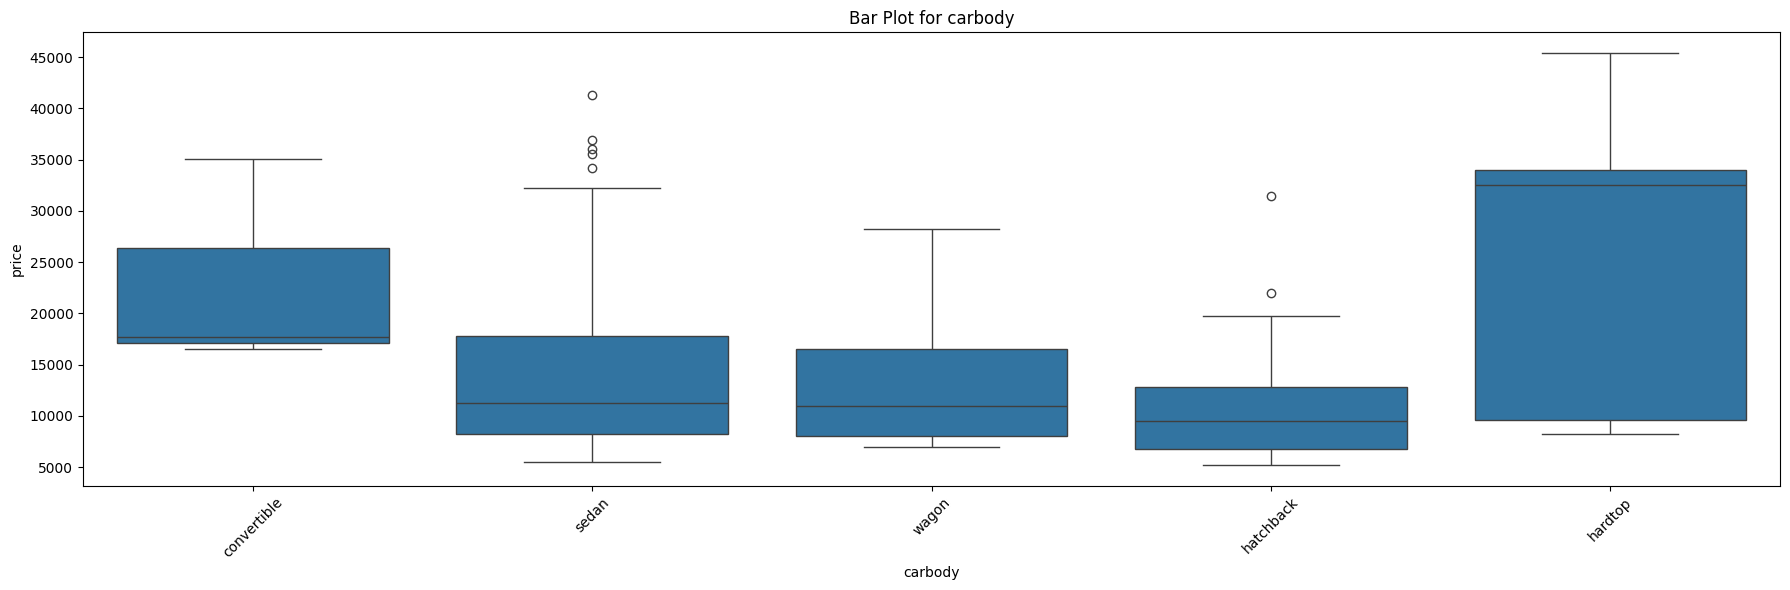

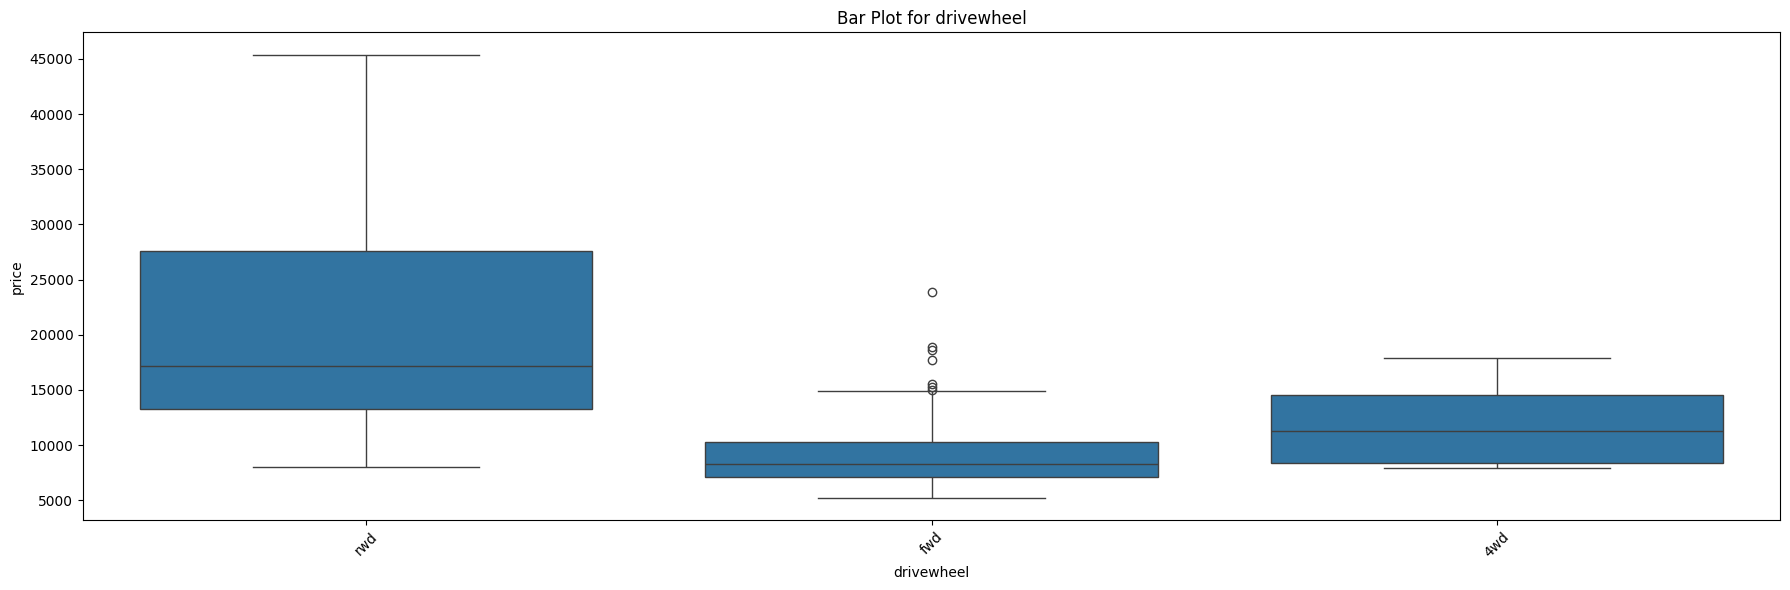

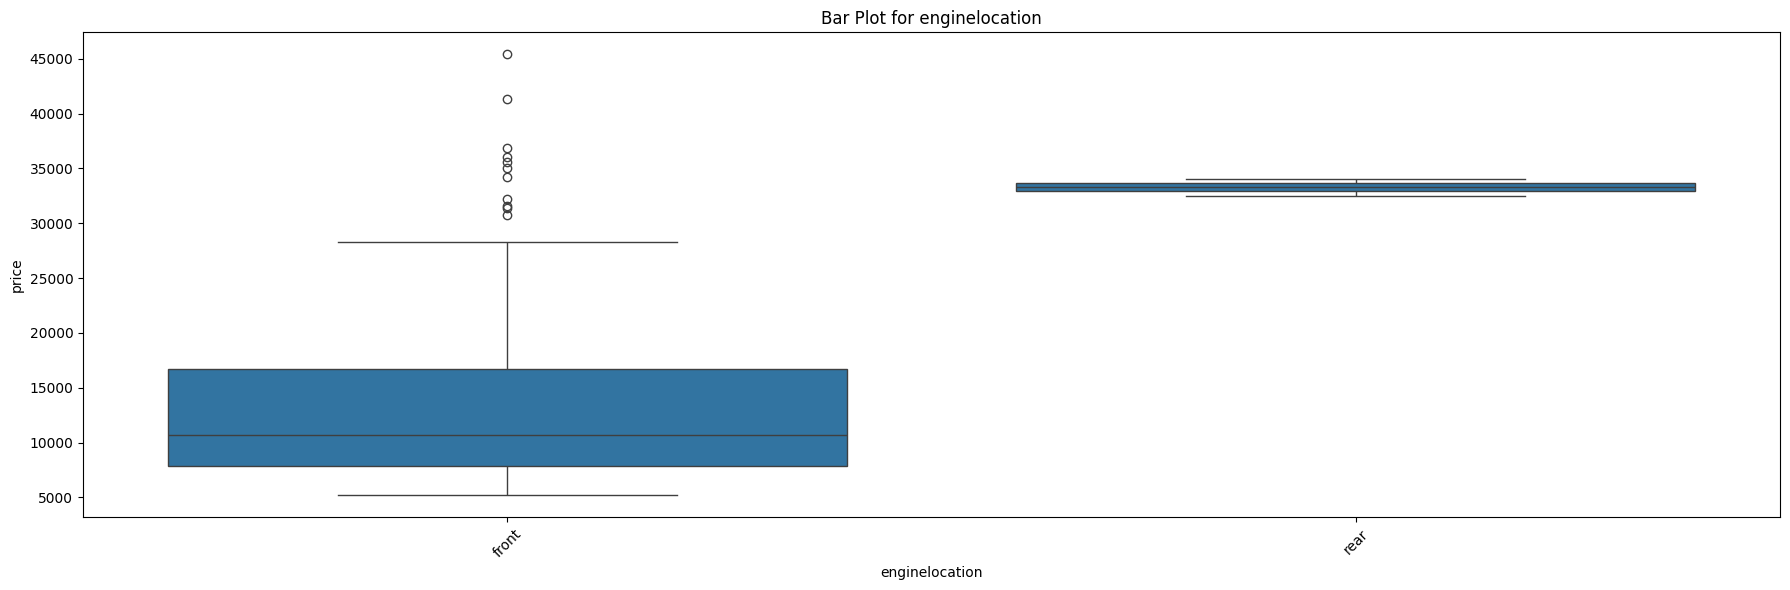

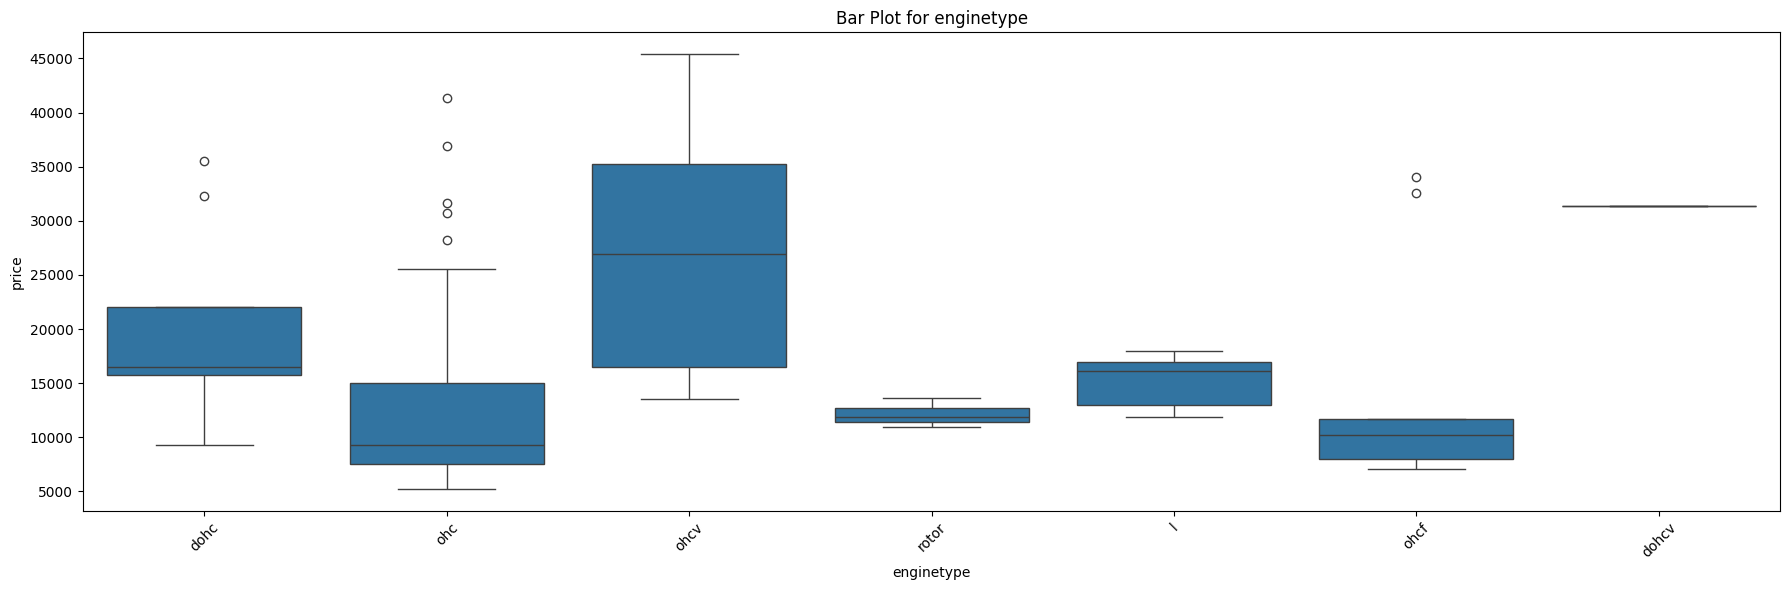

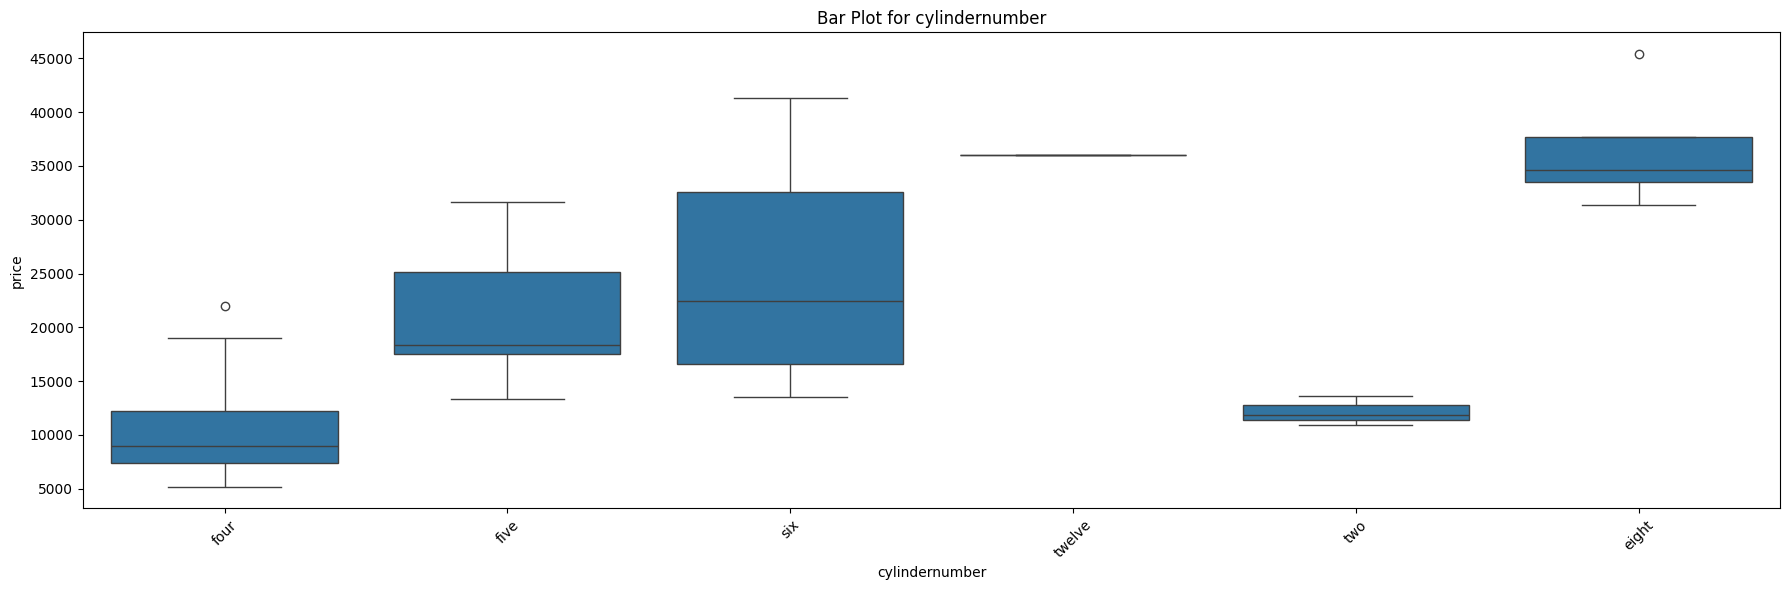

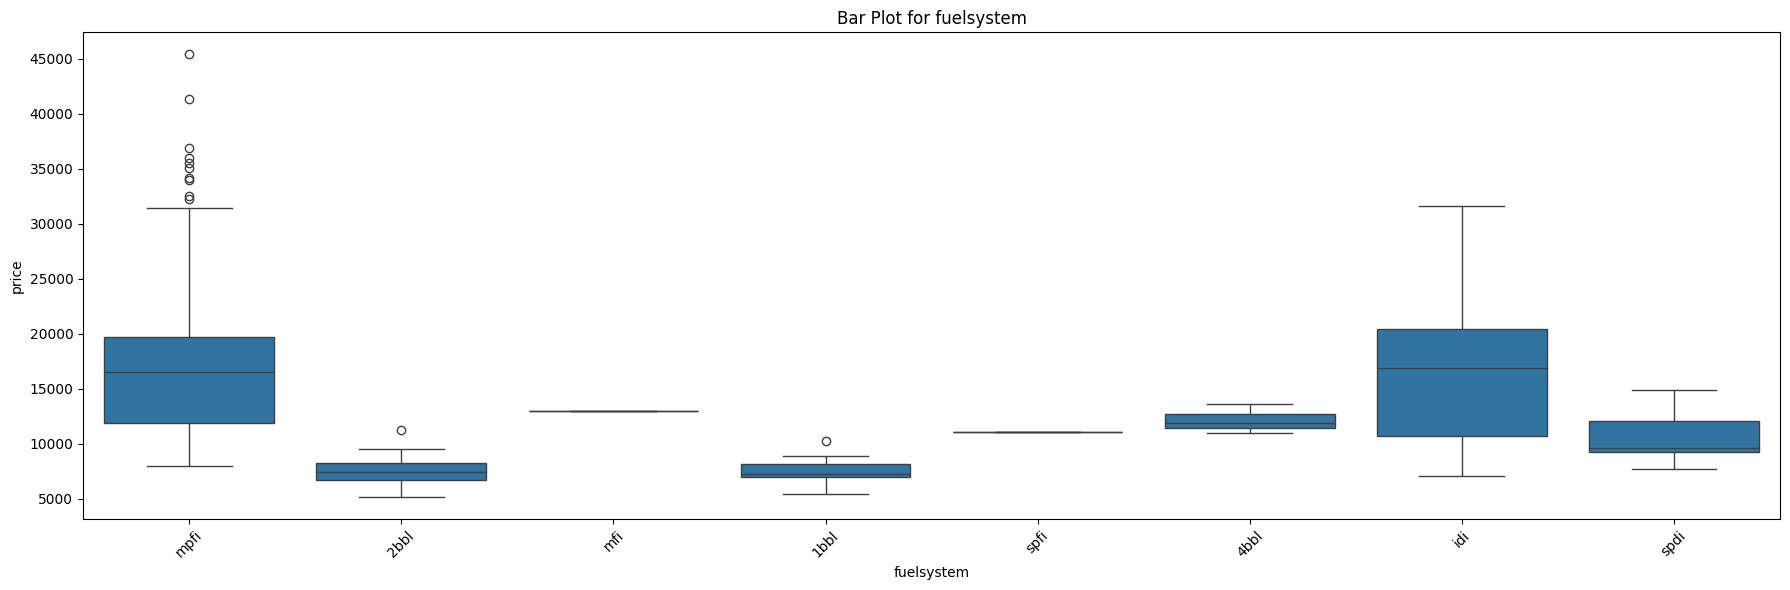

In [12]:
categorical_box_plot(train_data.to_pandas(),cat_cols,"price")

Some outliers present feature wise, they can be dropped or investigated in error analysis

**Performing Kruskal-Walli test (rank based) instead of ANOVA as data not following normal distribution**

In [13]:
perform_non_normal_kruskal_hypothesis(train_data,cat_cols,"price",alpha=0.05)

Kruskal-Wallis H-statistic: 4.641063240885674 P-value: 0.031215657007225634
There is a significant difference in price between different fueltype categories.

Kruskal-Wallis H-statistic: 13.472246140368902 P-value: 0.0002421182897620171
There is a significant difference in price between different aspiration categories.

Kruskal-Wallis H-statistic: 3.0173779823897773 P-value: 0.0823765534301663
There is no significant difference in price between different doornumber categories.

Kruskal-Wallis H-statistic: 14.741270074151037 P-value: 0.00526904954422455
There is a significant difference in price between different carbody categories.

Kruskal-Wallis H-statistic: 67.94961257484405 P-value: 1.757636673410337e-15
There is a significant difference in price between different drivewheel categories.

Kruskal-Wallis H-statistic: 4.766301855878229 P-value: 0.02902210276438481
There is a significant difference in price between different enginelocation categories.

Kruskal-Wallis H-statistic: 28.51

Dropping dorrnumber,fueltype

In [14]:
train_data=train_data.drop("doornumber")
test_data=test_data.drop("doornumber")
cat_cols.remove("doornumber")

train_data=train_data.drop("fueltype")  # near to 0.05
test_data=test_data.drop("fueltype")
cat_cols.remove("fueltype")

In [15]:
for i in cat_cols:
    print(train_data[i].value_counts())

shape: (2, 2)
┌────────────┬───────┐
│ aspiration ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ turbo      ┆ 28    │
│ std        ┆ 115   │
└────────────┴───────┘
shape: (5, 2)
┌─────────────┬───────┐
│ carbody     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ sedan       ┆ 71    │
│ convertible ┆ 3     │
│ hatchback   ┆ 44    │
│ wagon       ┆ 20    │
│ hardtop     ┆ 5     │
└─────────────┴───────┘
shape: (3, 2)
┌────────────┬───────┐
│ drivewheel ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ fwd        ┆ 82    │
│ 4wd        ┆ 7     │
│ rwd        ┆ 54    │
└────────────┴───────┘
shape: (2, 2)
┌────────────────┬───────┐
│ enginelocation ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ front          ┆ 141   │
│ rear           ┆ 2     │
└────────────────┴───────┘
shape: (7, 2)
┌────────────┬───────┐
│ enginetype ┆ count │
│ ---        

Many columns with less value counts

In [16]:
train_data.filter((train_data['enginelocation']=="rear"))

car_ID,symboling,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carclass,brandavg
i64,i64,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64
127,3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,32528.0,3.0,31964.25
128,3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,34028.0,3.0,31964.25


Enginelocation has only 2 entries with different categories can cause problems in cross validation results as in some cases the entire feature will be constant.dropping it can increase performance. And they they are probably sports cars

In [17]:
train_data=train_data.filter(~(train_data['enginelocation']=="rear"))
test_data=test_data.filter(~(test_data['enginelocation']=="rear"))
train_data=train_data.drop("enginelocation")
test_data=test_data.drop("enginelocation")

cat_cols.remove("enginelocation")

### Manual Imputing Categories

some insights are from powerbi reports

In [18]:
train_data= train_data.filter(~(train_data['enginetype']=='dohcv')) # only one observation
train_data=train_data.with_columns(train_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
train_data=train_data.with_columns(train_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
#imputing average prices from power bi
train_data=train_data.with_columns(train_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
train_data=train_data.with_columns(train_data["enginetype"].str.replace("dohcv","ohcv"))

test_data=test_data.with_columns(test_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
test_data=test_data.with_columns(test_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
test_data=test_data.with_columns(test_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
test_data=test_data.with_columns(test_data["enginetype"].str.replace("dohcv","ohcv"))

cat_cols.remove("drivewheel")
cat_cols.remove("cylindernumber")
num_cols.append("drivewheel")
num_cols.append("cylindernumber")

### Numerical eda

In [19]:
train_data[num_cols]

symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,carclass,brandavg,drivewheel,cylindernumber
i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64
3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,2.0,16500.0,1,9
2,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,3.0,17710.0,0,9
2,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,3.0,17710.0,0,19
2,99.8,177.3,66.3,53.1,2507,136,3.19,3.4,8.5,110,5500,19,25,3.0,17710.0,0,19
1,105.8,192.7,71.4,55.7,2844,136,3.19,3.4,8.5,110,5500,19,25,3.0,17710.0,0,19
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-2,104.3,188.8,67.2,56.2,3045,130,3.62,3.15,7.5,162,5100,17,22,3.0,18420.0,1,9
-1,104.3,188.8,67.2,57.5,3157,130,3.62,3.15,7.5,162,5100,17,22,3.0,18420.0,1,9
-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,3.0,18420.0,1,9


Univariate Analysis

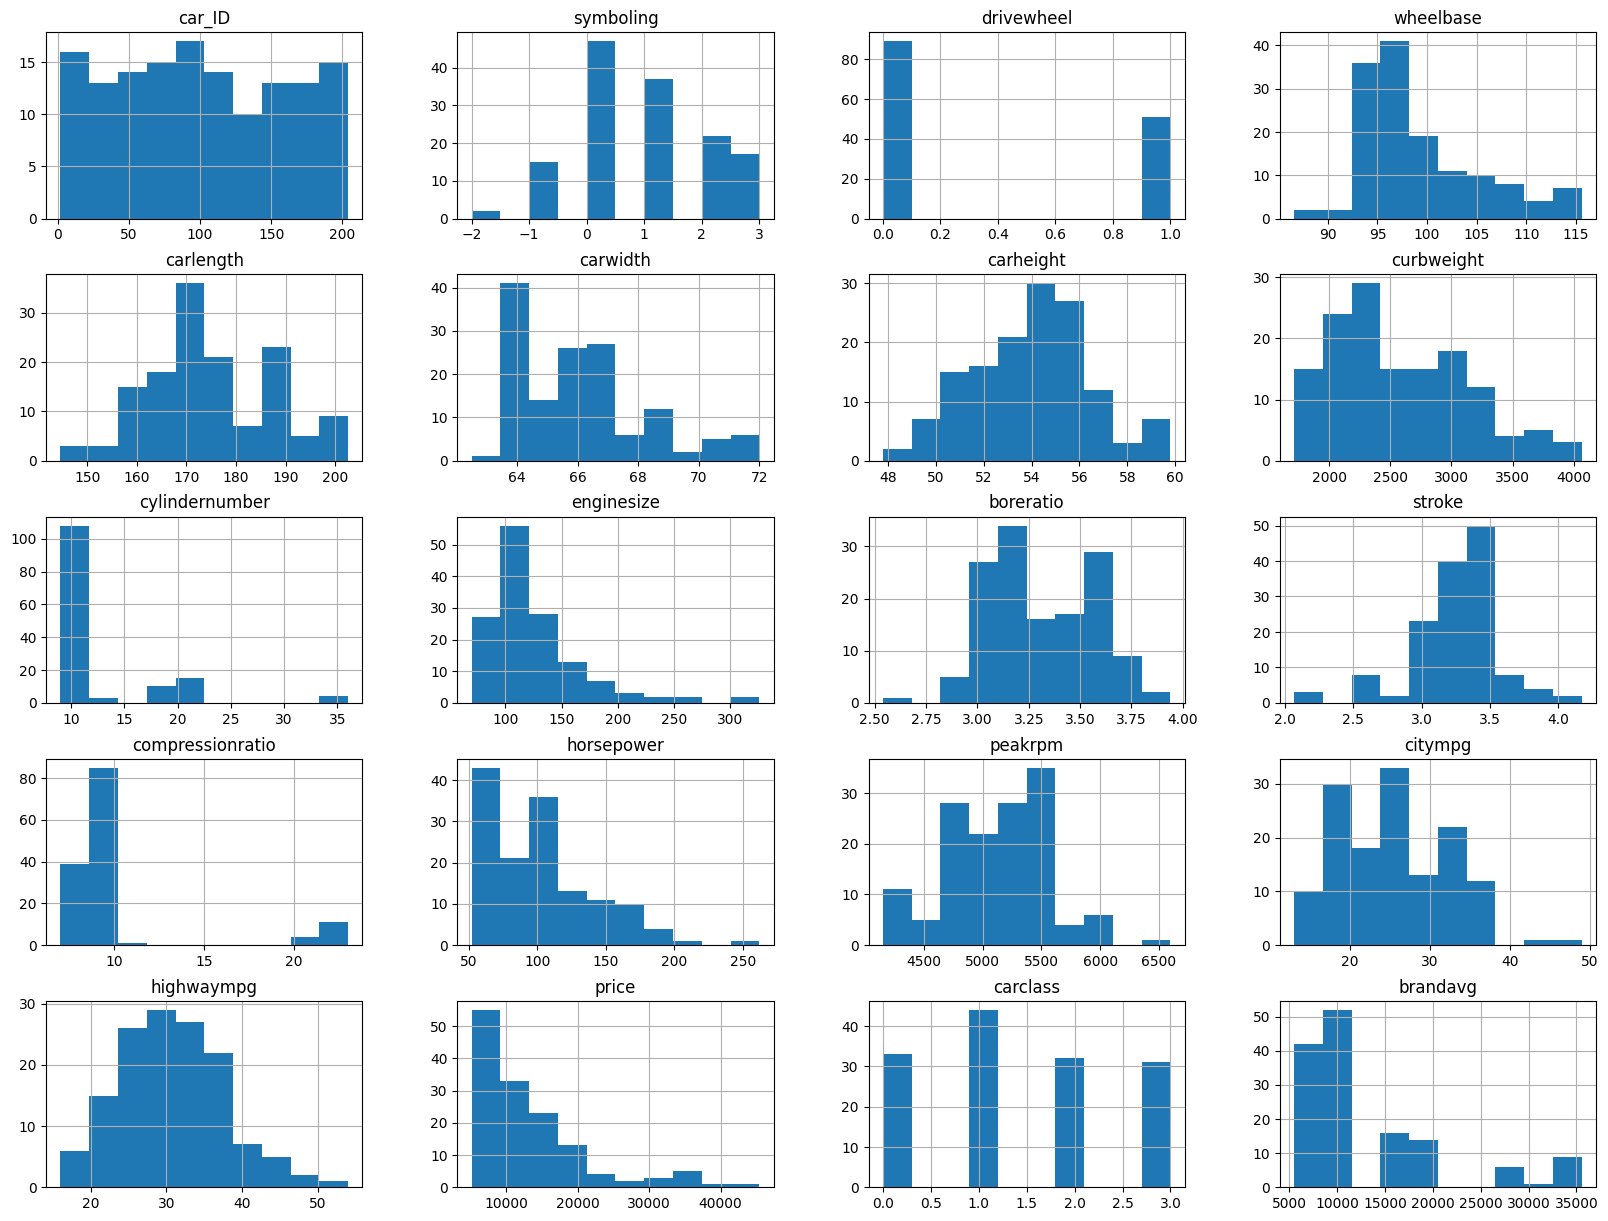

In [20]:
train_data.to_pandas().hist(bins=10,figsize=(20,15))
plt.show()

Most continuous features are roughly Normal, some are Right skewed including the dependent variable "Price"

Bivariate Analysis

<Axes: >

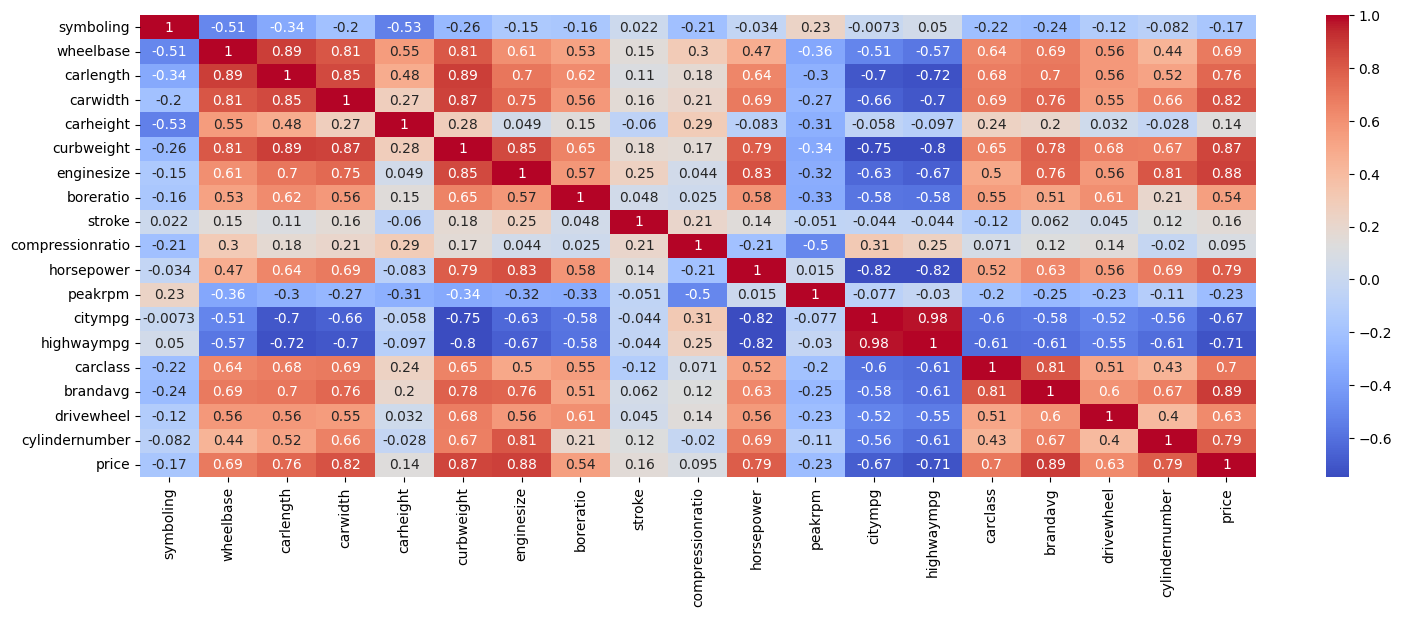

In [21]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm",robust=True)

Lot of Multi collinear features exists

Will deal with these multi collinear features based on modeling results

In [22]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

## Feature Engineering

In this section, we describe the feature engineering steps applied to the car dataset. The following new features have been created with the help of Chatgpt's domain knowldege to enhance the predictive power of our model:

### Average MPG
The `averagempg` feature provides a balanced measure of fuel efficiency, combining city and highway miles per gallon (MPG) using weighted averages.
US Environmental Protection Agency (EPA) uses a standard weighting of 55% city and 45% highway to calculate a combined fuel economy rating for vehicles https://www.epa.gov/fueleconomy

$$
\text{averagempg} = \frac{1}{\frac{0.55}{\text{citympg}} + \frac{0.45}{\text{highwaympg}}}
$$

In [23]:
train_data=train_data.with_columns((1/((0.55/train_data['citympg'])+(0.45/train_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')

test_data=test_data.with_columns((1/((0.55/test_data['citympg'])+(0.45/test_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')

num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

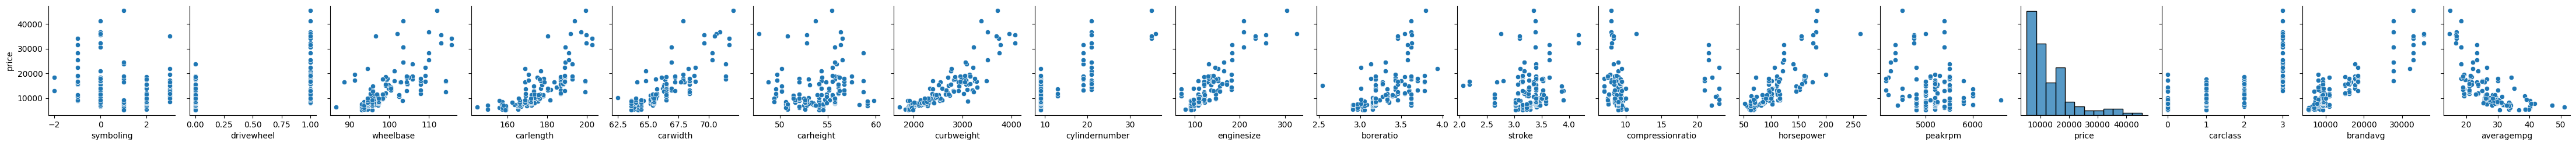

In [24]:
sns.pairplot(data=train_data.drop("car_ID").to_pandas(),y_vars="price")

Having more domain knowledge may even make use of these remaining features like compression ratio,enginetype etc

### variance Inflation factor checking

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False)

,variables,VIF
0,const,5720.304727
9,enginesize,18.325783
7,curbweight,17.477517
4,carlength,10.575075
3,wheelbase,10.189427
13,horsepower,9.478284
17,averagempg,8.447995
16,brandavg,7.744435
5,carwidth,7.725419
8,cylindernumber,6.564124


In [26]:
train_data=train_data.drop("enginesize","curbweight")
test_data = test_data.drop("enginesize","curbweight")
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False)

,variables,VIF
0,const,5597.958832
3,wheelbase,9.845642
4,carlength,9.774357
5,carwidth,7.275377
15,averagempg,6.316126
11,horsepower,5.833993
14,brandavg,5.766444
13,carclass,4.357062
7,cylindernumber,4.085637
8,boreratio,3.294957


### Feature selection by correlation

In [28]:
pearson = train_data[num_cols+["price"]].to_pandas().corr()['price'].sort_values(ascending=False).values
kendall = train_data[num_cols+["price"]].to_pandas().corr(method="kendall")['price'].sort_values(ascending=False).values
spearman = train_data[num_cols+["price"]].to_pandas().corr(method="spearman")['price'].sort_values(ascending=False).values

In [29]:
pd.DataFrame({"features": num_cols+["price"],"pearson":pearson,
              "kendall":kendall,
              "spearman":spearman})

,features,pearson,kendall,spearman
0,symboling,1.000000,1.000000,1.000000
1,drivewheel,0.893658,0.682547,0.857795
2,wheelbase,0.824668,0.675704,0.855904
3,carlength,0.793634,0.660655,0.842124
4,carwidth,0.791244,0.623231,0.772647
5,carheight,0.758004,0.598968,0.760117
6,cylindernumber,0.696099,0.598666,0.726331
7,boreratio,0.686256,0.545611,0.667425
8,stroke,0.625195,0.517128,0.665693
9,compressionratio,0.538276,0.504786,0.632749


In [30]:
from sklearn.feature_selection import mutual_info_regression

X = train_data[num_cols]
y = train_data['price']

mutual_info = mutual_info_regression(X, y)
mi_series = pd.Series(mutual_info, index=X.columns)
mi_series.sort_values(ascending=False)


horsepower          0.797369
carwidth            0.738931
brandavg            0.701104
averagempg          0.686944
carlength           0.639182
wheelbase           0.516461
carclass            0.468619
boreratio           0.453643
cylindernumber      0.345705
drivewheel          0.257168
symboling           0.217767
carheight           0.174215
stroke              0.160780
peakrpm             0.158178
compressionratio    0.083599
dtype: float64

dropping low mutual information features

In [31]:
train_data=train_data.drop('wheelbase', 'carclass', 'boreratio', 'cylindernumber', 'drivewheel',
       'symboling', 'carheight', 'peakrpm', 'stroke', 'compressionratio')
test_data=test_data.drop('wheelbase', 'carclass', 'boreratio', 'cylindernumber', 'drivewheel',
       'symboling', 'carheight', 'peakrpm', 'stroke', 'compressionratio')
#engine location very few observations so not dropping
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

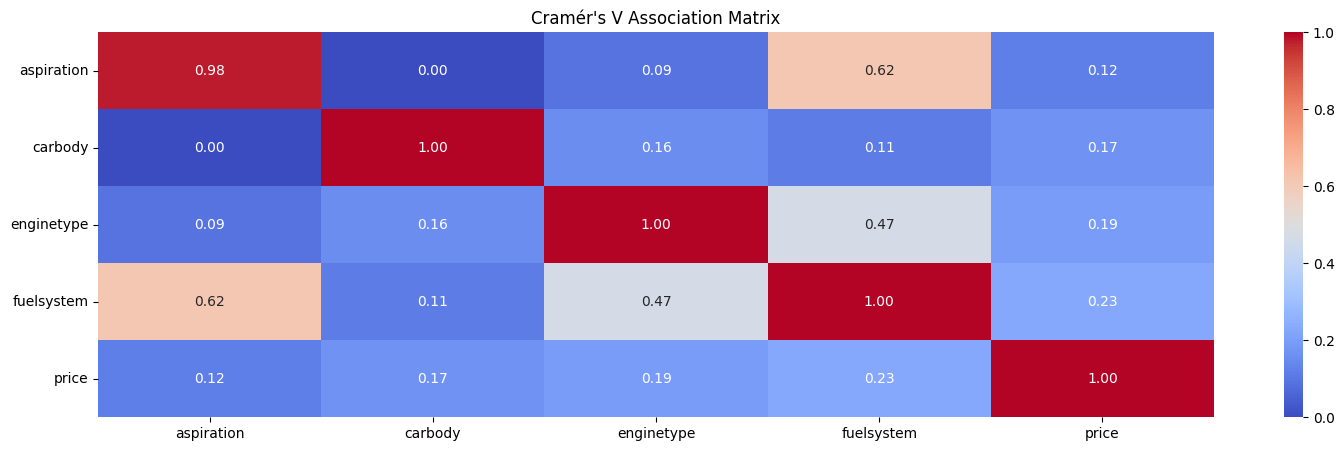

In [32]:
plot_Association_heatmap(train_data[cat_cols+["price"]],cat_cols+["price"])

In [33]:
train_data = train_data.drop(cat_cols)
test_data = test_data.drop(cat_cols)

## Baseline Modeling

Mean Train Score: 0.899893946919665
Standard Deviation of Train Scores: 0.006427689647895312
Mean Test Score: 0.8560888625782879
Standard Deviation of Test Scores: 0.09517469729575413
Mean absolute Error: 1645.7022499604532
R-squared on holdout set: 0.8645928677964468
Adjusted R-squared on holdout set: 0.8522831285052147


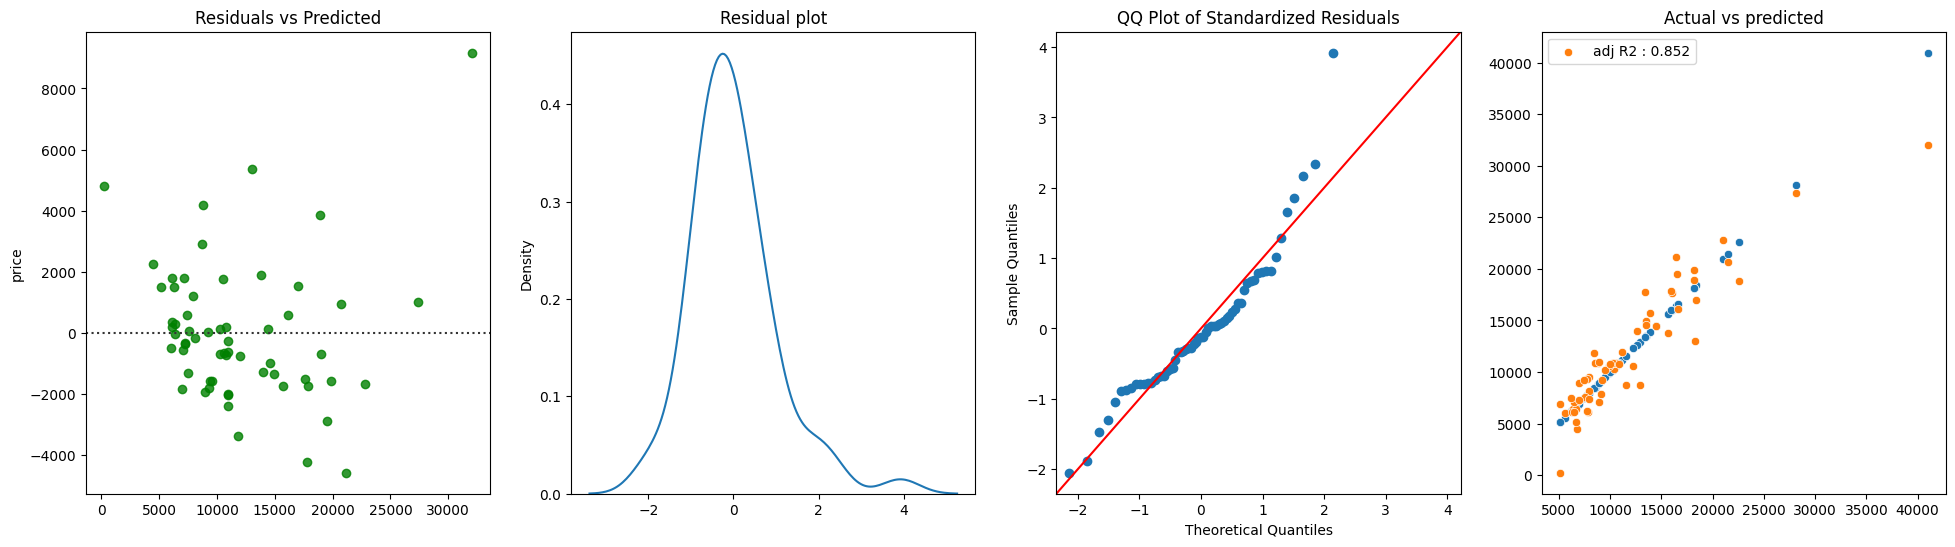

In [34]:
#pipeline building
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])

from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test, y=predictions, ax=ax4, label=f"adj R2 : {round(adjusted_r2, 3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

## Regularization

In [35]:
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
imputer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge performed better from week 1 analysis

### Ridge Regression

Mean Train Score: 0.8981344957354308
Standard Deviation of Train Scores: 0.006475293769688404
Mean Test Score: 0.8588942861382864
Standard Deviation of Test Scores: 0.09474975699036475
Mean absolute Error: 1664.4865271147344
R-squared on holdout set: 0.8392276037893953
Adjusted R-squared on holdout set: 0.824611931406613


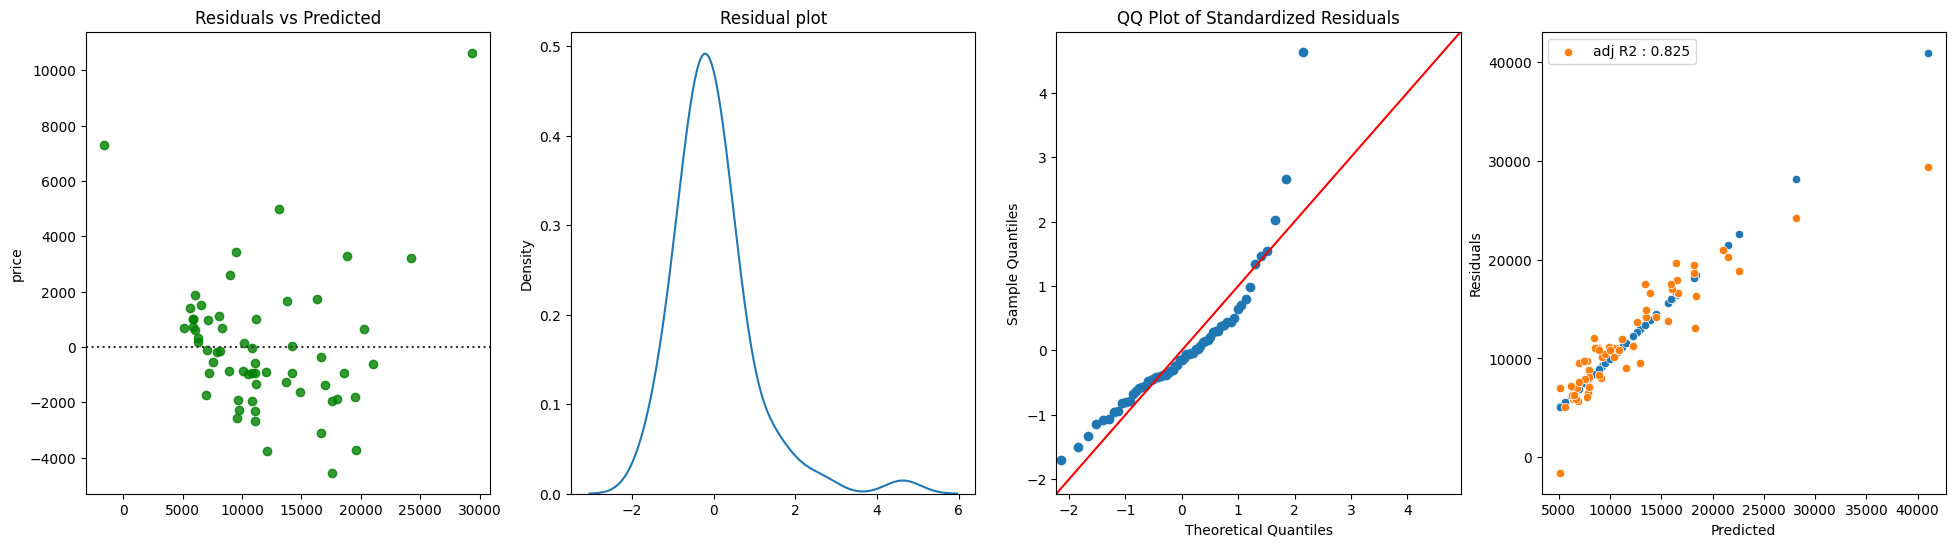

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict,RepeatedKFold,cross_validate
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

ridge_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Ridge())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
ridge_bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=50, cv=rkf, n_jobs=-1, random_state=42)
ridge_bayes_search.fit(X_train, y_train)

best_alpha = ridge_bayes_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_results = cross_validate(ridge_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(ridge_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test, y=predictions, ax=ax4, label=f"adj R2 : {round(adjusted_r2, 3)}")
plt.show()

In [38]:
ridge_bayes_search.best_params_

OrderedDict([('regressor__alpha', 6.439441094401297)])

## Error Analysis
- This part delves into error analysis to gain insights into the nature and distribution of errors in our regression model.

### Extracting and Analyzing the residuals from previous modeling

Mean absolute Error: 1664.4865271147344
R-squared on holdout set: 0.8392276037893953
Adjusted R-squared on holdout set: 0.824611931406613


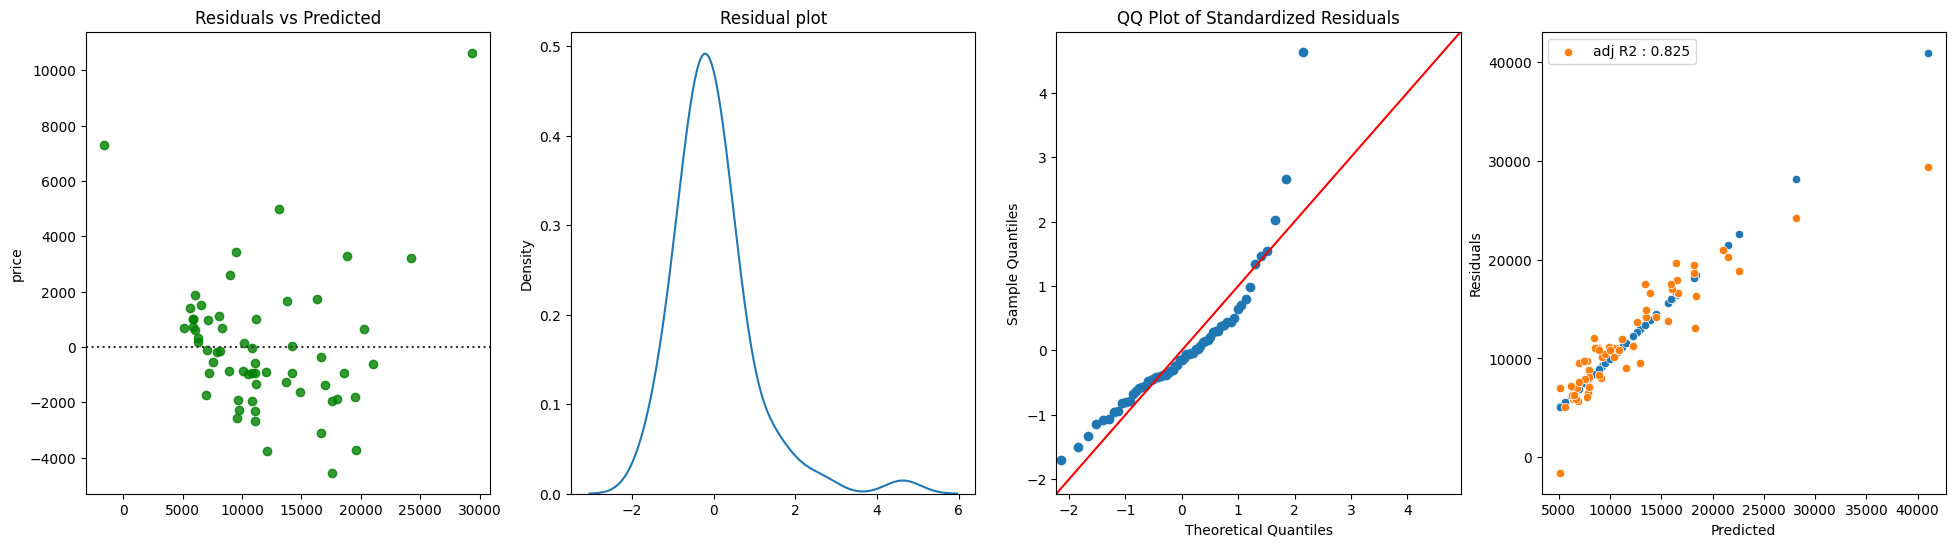

In [39]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

sc=StandardScaler()
predictions = cross_val_predict(ridge_pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test, y=predictions, ax=ax4, label=f"adj R2 : {round(adjusted_r2, 3)}")
plt.show()

In [40]:
outliers=np.where(np.std(residuals)*1.7<residuals)[0]
test_data[outliers].hstack(pl.DataFrame(predictions,schema=["predictions"])[outliers])

car_ID,carlength,carwidth,horsepower,price,brandavg,averagempg,predictions
i64,f64,f64,i64,f64,f64,f64,f64
19,141.1,60.3,48,5151.0,6435.0,49.522863,-1580.2343
66,175.0,66.1,120,18280.0,10945.0,21.923077,13126.81546
74,208.1,71.7,184,40960.0,32892.0,14.834437,29342.574443


- 1 obeservation deviating a lot it can porbably a outlier
- car with low price predicted as -ve

### Testing

#### Shapiro-Wilk Test: 
- Used to test the normality of the residuals. If the p-value is less than 0.05, the null hypothesis that the data is normally distributed is rejected.

In [41]:
from scipy.stats import shapiro

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk test: Statistic=0.8552395105361938, p-value=3.7434153909998713e-06


#### Failed
- Residuals are not normally distributed

#### Breusch-Pagan Test: 
- Tests for homoscedasticity (constant variance of the residuals). If the p-value is less than 0.05, the null hypothesis of homoscedasticity is rejected.

In [42]:
X_test_transformed = imputer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=imputer.get_feature_names_out())
# # Add a constant (intercept term)
X_test_transformed = sm.add_constant(X_test_transformed)

In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier statistic': 19.296051884691913, 'p-value': 0.001692692605580507, 'f-value': 5.089603750338904, 'f p-value': 0.0006624404586661956}


#### Failed  
- Heteroskedastic residuals present

Logging some features could decrease the Heteroscedastic residuals little bit

#### Durbin-Watson Test: 
- Tests for autocorrelation in the residuals. Values close to 2 indicate no autocorrelation, while values deviating significantly from 2 suggest positive or negative autocorrelation.

In [44]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")

Durbin-Watson test statistic: 1.510125086945966


#### Failed
- Some Negative autocorrelation present

#### Multi-collinearity test

In [45]:
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(imputer.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Condition number: 6.0282


#### Passed
- very less multicollinearity

### Solutions
- There might be omitted features which could capture heteroskedacity
- Function form of features (ex: feature engineered ones) would be wrong (for heteroskedastic residuals) also
- Transforming the target variable (Right skewed) . Interpretation will not be straight forward (doing here)

In [46]:
# sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars='price')

### Transforming Target variable

In [47]:
train_data=train_data.with_columns(train_data['price'].log10())
test_data=test_data.with_columns(test_data['price'].log10())

In [48]:
train_data

car_ID,carlength,carwidth,horsepower,price,brandavg,averagempg
i64,f64,f64,i64,f64,f64,f64
2,168.8,64.1,111,4.217484,16500.0,23.333333
4,176.6,66.2,102,4.144574,17710.0,26.373626
5,176.6,66.4,115,4.241795,17710.0,19.60396
6,177.3,66.3,110,4.18327,17710.0,21.300448
7,192.7,71.4,110,4.248219,17710.0,21.300448
…,…,…,…,…,…,…
199,188.8,67.2,162,4.26529,18420.0,18.936709
200,188.8,67.2,162,4.277609,18420.0,18.936709
201,188.8,68.9,114,4.226471,18420.0,25.009709


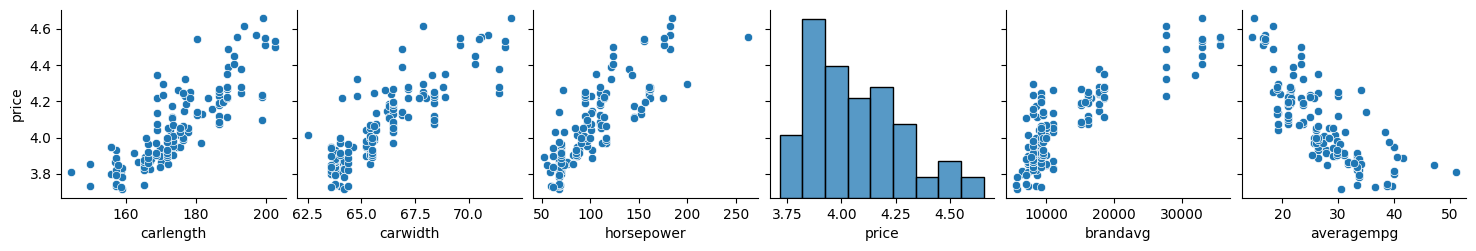

In [49]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars='price')

### Removing high inflential points

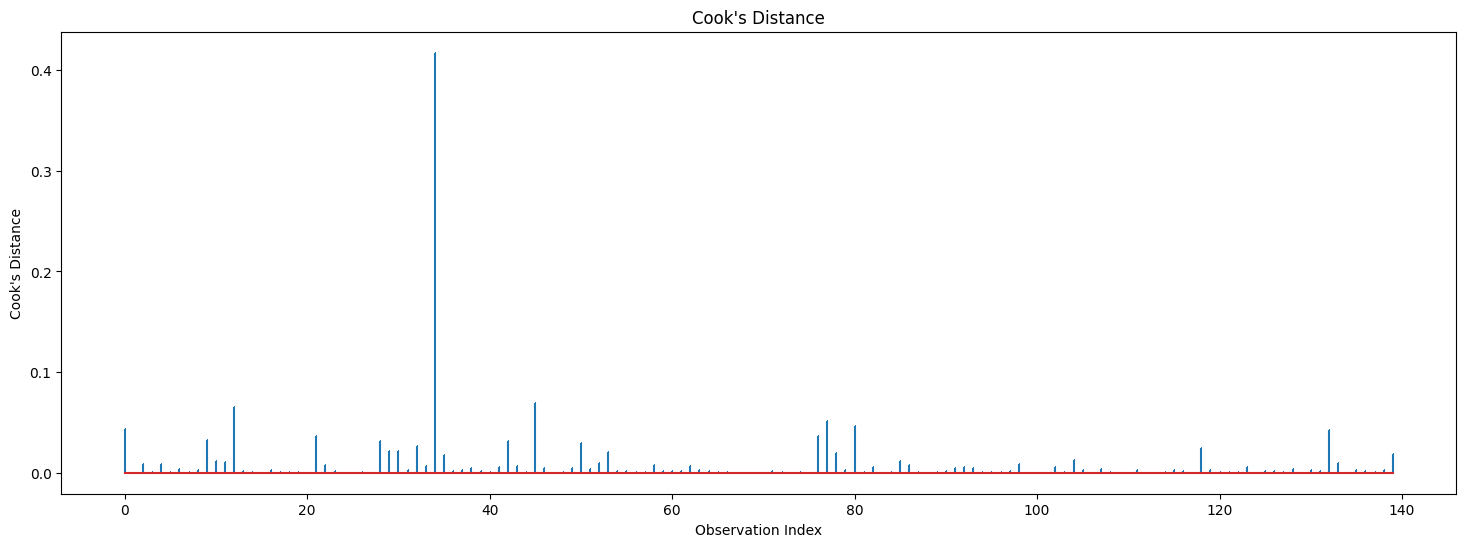

Influential Points: [34]


In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the dependent and independent variables
X = train_data.drop("price","car_ID").to_pandas()
y = train_data["price"].to_pandas()
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]
imputer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
X=imputer.fit_transform(X)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get influence metrics
influence = model.get_influence()

# Calculate Cook's distance
cooks_d = influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(18, 6))
plt.stem(np.arange(len(cooks_d[0])), cooks_d[0], markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()
n_samples = len(y)
influential_points = np.where(cooks_d[0] > 0.1)[0]  # Arbitary
print("Influential Points:", influential_points)

In [51]:
train_data=train_data.filter(~(train_data["car_ID"].is_in(train_data[influential_points]["car_ID"])))

Having domain knowledge may tune these new features well and know what other features are crucial for car price

Mean Train Score: 0.9085117566467608
Standard Deviation of Train Scores: 0.006357880668097834
Mean Test Score: 0.8800641566351665
Standard Deviation of Test Scores: 0.07824697334762006
Mean absolute Error: 0.05373547983481764
R-squared on holdout set: 0.8723795835898397
Adjusted R-squared on holdout set: 0.8607777275525523


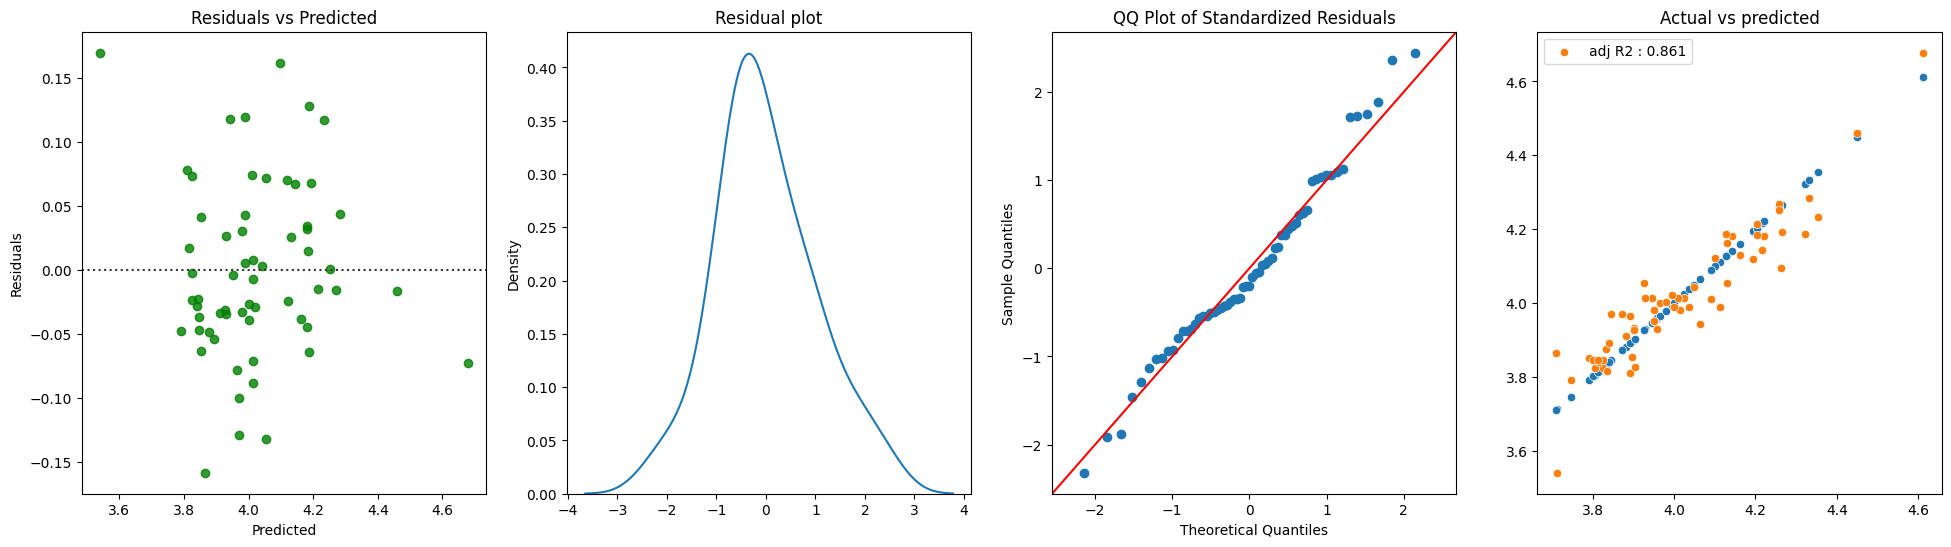

In [52]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm
from skopt import BayesSearchCV
from skopt.space import Real

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]
imputer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', Ridge())
])
param_space = {
    'regressor__alpha': Real(1e-4, 1e3, prior='log-uniform'),
}
rkf=RepeatedKFold(n_splits=10,random_state=42)
# Initialize the Bayesian search
bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=25, cv=rkf, n_jobs=-1, random_state=42)

# Fit the search
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = bayes_search.best_params_['regressor__alpha']

# Set the best hyperparameters to the pipeline
ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_results = cross_validate(ridge_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(ridge_pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test, y=predictions, ax=ax4, label=f"adj R2 : {round(adjusted_r2, 3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

In [53]:
bayes_search.best_params_['regressor__alpha']

5.233686714028822

Mean absoulte error on original scale

In [54]:
predictions = cross_val_predict(ridge_pipe, X_test, y_test)
residuals = y_test - predictions
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed = y_test
predictions_transformed = predictions

# Convert predictions back to original scale
y_test_original = 10**y_test_transformed
predictions_original = 10**predictions_transformed

# Calculate the absolute error in the original scale
abs_error_original = np.abs(y_test_original - predictions_original)

# Calculate mean absolute error in the original scale
mae_original = np.mean(abs_error_original)

print("Mean Absolute Error in Original Scale:", mae_original)

Mean Absolute Error in Original Scale: 1428.3551168725887


### Testing After Changes

In [55]:
# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")
# Residuals Normailty check
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
# Breusch-Pagan test for Homoscedastic residuals
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Multi-collinearity
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(imputer.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Durbin-Watson test statistic: 1.4446831597232082
Shapiro-Wilk test: Statistic=0.9780619144439697, p-value=0.34148553013801575
{'Lagrange multiplier statistic': 5.670263961886581, 'p-value': 0.33963671445625876, 'f-value': 1.1272944359934658, 'f p-value': 0.3568910636357131}
Condition number: 5.5898


- Autocorrelation decreased little
- Residuals are more likely to follow Normal distribution (Some Outliers may present in hold-out Set)
- Strongly Homoscedastic residuals
- No multi-collinearity (little bit increased)

### Pipeline Building

In [56]:
ridge_pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['carlength', 'carwidth',
                                                   'horsepower', 'brandavg',
                                                   'averagempg'])])),
                ('regressor', Ridge(alpha=5.233686714028822))])

In [57]:
import joblib
joblib.dump(ridge_pipe,"carprice.joblib")

['carprice.joblib']

## Conclusion
- The statistical tests and diagnostics confirm that the models meet the assumptions of linear regression. And we are Explaining about 85% of data variation